# Reconhecimento de Captchas

**Aluno:** Pedro de Oliveira Guedes

**Semestre:** 2024.2

## Introdução
Este trabalho tem por objetivo explorar diferentes técnicas para realizar o reconhecimento de caracteres em imagens, mais especificamente em captchas. Para isso, será utilizado um dataset com 10 mil captchas disponibilizado nos arquivos de aula da disciplina de **Introdução à Computação Visual**.

As técnicas empregadas são duas:

1. **HOG + SVM**: ***Histogram of Oriented Gradients***, ou por abreviação ***HOG***, é uma técnica que extrai características de uma imagem baseando-se na orientação dos gradientes. Com as características extraídas, será treinado um modelo de classificação baseado em ***Support Vector Machine***, ou por abreviação ***SVM***, que utilizará as características extraídas e os rótulos das imagens para classificar os caracteres.

2. **CNN**: ***Convolutional Neural Network***, ou por abreviação ***CNN***, é uma técnica de aprendizado profundo que utiliza camadas convolucionais para extrair características de uma imagem. Com as características extraídas, será treinado um modelo de classificação que utilizará as características extraídas e os rótulos das imagens para classificar os caracteres.

Como as imagens necessárias para treino, validação e teste, bem como os rótulos de cada uma delas, já foram fornecidas e já estão separadas, a organização deste trabalho será feita através das seguintes seções:

1. **Funções Comuns**: Nesta seção, serão definidas funções comuns que serão utilizadas em ambas as técnicas, como a avaliação dos modelos gerados.

2. **HOG + SVM**: Nesta seção, será feita a extração das características das imagens utilizando a técnica ***HOG***, bem como o treinamento do modelo de classificação utilizando a técnica ***SVM***. Ao fim, será feita a avaliação do modelo gerado.

3. **CNN**: Nesta seção, será feita a extração das características das imagens utilizando a técnica ***CNN***, bem como o treinamento do modelo de classificação. Ao fim, será feita a avaliação do modelo gerado.

4. **Conclusão**: Nesta seção, será feita uma comparação entre as técnicas utilizadas, bem como uma análise dos resultados obtidos.

## Funções Comuns
Cada uma das funções comuns terá seu próprio subtítulo, com uma breve descrição do objetivo.

### Download e extração do Dataset
A pasta contendo os captchas separados em conjuntos de treino, validação e teste foi disponibilizada no Google Drive. A função abaixo faz o download para a pasta local e extrai o conteúdo do arquivo.

In [3]:
import os
import requests
import zipfile


def save_response_content(response):
    CHUNK_SIZE = 32768

    with open("captcha_10k.zip", "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk:
                f.write(chunk)


def extract_captchas_zip():
    with zipfile.ZipFile("captcha_10k.zip", 'r') as zip_ref:
        zip_ref.extractall()

    os.remove("captcha_10k.zip")


def extract_query_string(response_content: str) -> dict:
    content_id = response_content.split('<input type="hidden" name="id" value="')[1].split('">')[0]
    export = response_content.split('<input type="hidden" name="export" value="')[1].split('">')[0]
    confirm = response_content.split('<input type="hidden" name="confirm" value="')[1].split('">')[0]
    uuid = response_content.split('<input type="hidden" name="uuid" value="')[1].split('">')[0]

    return {
        'id': content_id,
        'export': export,
        'confirm': confirm,
        'uuid': uuid
    }


def download_captchas_from_google_drive():
    if os.path.exists("captcha_10k"):
        return

    BASE_URL = "https://drive.google.com/uc?export=download"
    DOWNLOAD_BASE_URL = "https://drive.usercontent.google.com/download"

    session = requests.Session()
    response = session.get(BASE_URL, params={'id': "1mZlwRlSOeNBjFYFzI25RgKvomKRHeJ1Y"}, stream=True)
    
    query_string = extract_query_string(response.text)
    
    response = session.get(DOWNLOAD_BASE_URL, params=query_string, stream=True)
    
    save_response_content(response)

    extract_captchas_zip()

### Carregamento do Dataset
A função abaixo passa por todo o dataset de captchas, armazenando as imagens e os rótulos em um dicionário. Os dicionários serão agrupados em três listas separadas, uma para cada conjunto de dados: treino, validação e teste.

In [4]:
import cv2 as opencv


TRAIN = "train"
TEST = "test"
VALIDATION = "validation"

SET_TYPES = [TRAIN, TEST, VALIDATION]


def load_captchas_dataset() -> dict:
    download_captchas_from_google_drive()

    all_captchas = {}
    for filename in os.listdir("captcha_10k/labels"):
        with open(f"captcha_10k/labels/{filename}", 'r') as f:
            all_captchas[filename.split('.')[0]] = {"label": f.read().strip()}
    
    for folder in SET_TYPES:
        for filename in os.listdir(f"captcha_10k/{folder}"):
            file_number = filename.split('.')[0]
            image = opencv.imread(f"captcha_10k/{folder}/{filename}", opencv.IMREAD_GRAYSCALE)
            all_captchas[file_number]["image"] = image / 255.0
            all_captchas[file_number]["type"] = folder

    train_captchas = [all_captchas[filename] for filename in all_captchas if all_captchas[filename]["type"] == TRAIN]
    test_captchas = [all_captchas[filename] for filename in all_captchas if all_captchas[filename]["type"] == TEST]
    validation_captchas = [all_captchas[filename] for filename in all_captchas if all_captchas[filename]["type"] == VALIDATION]

    return {
        TRAIN: train_captchas,
        TEST: test_captchas,
        VALIDATION: validation_captchas
    }


captchas = load_captchas_dataset()

### Exibição dos Captchas
Para entender melhor as imagens, a função abaixo fará a exibição de três delas em conjunto com seus respectivos rótulos.

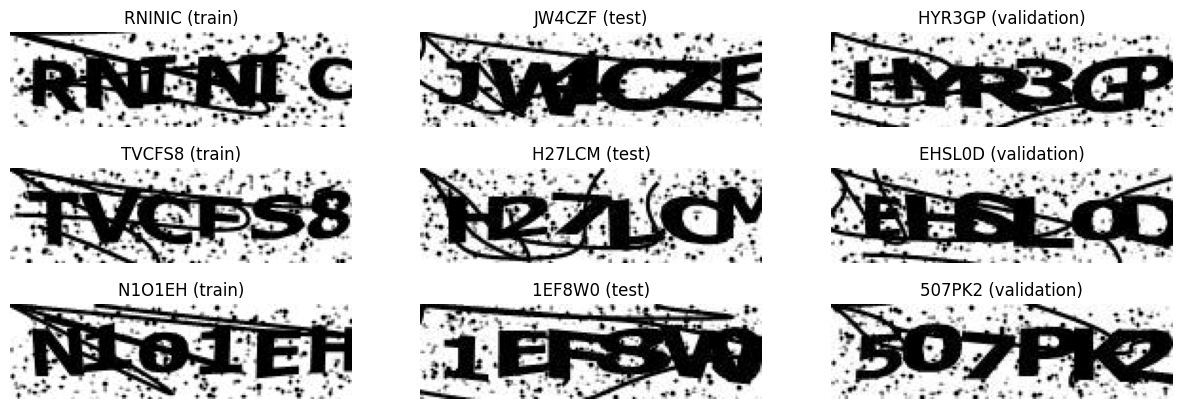

In [5]:
import matplotlib.pyplot as plt


def plot_captchas(captchas: dict, amount_per_type: int = 3):
    _, axs = plt.subplots(amount_per_type, len(SET_TYPES), figsize=(15, 5), squeeze=False)

    for set_type in SET_TYPES:
        for i, captcha in enumerate(captchas[set_type]):
            if i >= amount_per_type:
                break
            axs[i, SET_TYPES.index(set_type)].imshow(captcha["image"], cmap="gray")
            axs[i, SET_TYPES.index(set_type)].set_title(f"{captcha['label']} ({set_type})")
            axs[i, SET_TYPES.index(set_type)].axis("off")

    plt.show()


plot_captchas(captchas)

### Estatísticas dos Captchas
Para melhor entendimento das tratativas necessárias no conjunto de dados, também serão coletadas estatísticas sobre o tamanho das imagens, quantidade de caracteres em cada imagem e quantidade de caracteres total disponível para construção dos captchas.

In [6]:
import pandas as pd


def analyze_captchas_dataset(captchas: dict) -> pd.DataFrame:
    dataset = {
        set_type: { "total": len(captchas[set_type]) } for set_type in SET_TYPES
    }

    for set_type in SET_TYPES:
        distinct_characters = set()
        for captcha in captchas[set_type]:
            for character in captcha["label"]:
                distinct_characters.add(character)

        dataset[set_type]["min_label_length"] = min(len(captcha["label"]) for captcha in captchas[set_type])
        dataset[set_type]["max_label_length"] = max(len(captcha["label"]) for captcha in captchas[set_type])
        dataset[set_type]["distinct_characters"] = len(distinct_characters)
        dataset[set_type]["min_width"] = min(captcha["image"].shape[1] for captcha in captchas[set_type])
        dataset[set_type]["min_height"] = min(captcha["image"].shape[0] for captcha in captchas[set_type])
        dataset[set_type]["max_width"] = max(captcha["image"].shape[1] for captcha in captchas[set_type])
        dataset[set_type]["max_height"] = max(captcha["image"].shape[0] for captcha in captchas[set_type])

    return pd.DataFrame(dataset).T


dataset_analysis = analyze_captchas_dataset(captchas)
dataset_analysis

,total,min_label_length,max_label_length,distinct_characters,min_width,min_height,max_width,max_height
train,8000,6,7,37,180,50,180,50
test,1000,6,7,36,180,50,180,50
validation,1000,6,7,36,180,50,180,50


É possível verificar que todas as imagens possuem as mesmas dimensões de 50x180 pixels, dispensando a necessidade de redimensionamento.

Note que no conjunto de treino existem 37 caracteres distintos, enquanto nos conjuntos de validação e teste existem 36, o que pode levar a predições não reconhecidas.

Além disso, perceba também a diferença entre o tamanho máximo e mínimo de caracteres nos rótulos. Esse problema em específico precisa ser tratado, já que o modelo de classificação espera que todas as imagens tenham o mesmo tamanho de rótulo.

In [7]:
def remove_captchas_with_over_6_characters(captchas: dict) -> dict:
    return {
        set_type: [captcha for captcha in captchas[set_type] if len(captcha["label"]) == 6] for set_type in SET_TYPES
    }

captchas = remove_captchas_with_over_6_characters(captchas)

dataset_analysis = analyze_captchas_dataset(captchas)
dataset_analysis

,total,min_label_length,max_label_length,distinct_characters,min_width,min_height,max_width,max_height
train,7997,6,6,37,180,50,180,50
test,999,6,6,36,180,50,180,50
validation,999,6,6,36,180,50,180,50


### Adição de bordas para a imagem
Note que o mínimo divisor comum entre as dimensões das imagens (50x180) é 10. Para o algoritmo HOG, que divide a imagem em células de 8x8 pixels, é necessário que as dimensões da imagem sejam múltiplas de 8.

O objetivo da função abaixo é adicionar bordas à imagem de forma que as dimensões da imagem sejam múltiplas do tamanho dos blocos, que é informado como parâmetro.

In [8]:
import math


def pad_image(
    image: opencv.typing.MatLike,
    block_size: int = 8,
    border_type: int = opencv.BORDER_CONSTANT,
) -> opencv.typing.MatLike:
    height, width = image.shape

    if height % block_size == 0 and width % block_size == 0:
        return image

    final_height = math.ceil(height / block_size) * block_size
    final_width = math.ceil(width / block_size) * block_size
    
    top = math.ceil((final_height - height) / 2)
    bottom = math.floor((final_height - height) / 2)
    left = math.ceil((final_width - width) / 2)
    right = math.floor((final_width - width) / 2)

    return opencv.copyMakeBorder(
        src=image,
        top=top,
        bottom=bottom,
        left=left,
        right=right,
        borderType=border_type,
        dst=None,
    )

### Mapeamento de Rótulos
Os rótulos das imagens são strings contendo os caracteres presentes no captcha. Para facilitar o treinamento dos modelos, é necessário mapear cada caractere para um número inteiro.

A função abaixo faz o mapeamento dos caracteres para números inteiros, retornando dois dicionários: um mapeando os caracteres para números inteiros e outro mapeando os números inteiros para caracteres.

In [9]:
def get_captchas_characters_mapping(captchas: dict) -> tuple[dict, dict]:
    characters = set()
    for set_type in [TRAIN, TEST, VALIDATION]:
        for captcha in captchas[set_type]:
            for character in captcha["label"]:
                characters.add(character)

    characters = sorted(list(characters))
    char_to_int = {character: i for i, character in enumerate(characters)}
    int_to_char = {i: character for i, character in enumerate(characters)}

    return char_to_int, int_to_char


char_to_int, int_to_char = get_captchas_characters_mapping(captchas)
print(char_to_int)
print(int_to_char)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '?': 10, 'A': 11, 'B': 12, 'C': 13, 'D': 14, 'E': 15, 'F': 16, 'G': 17, 'H': 18, 'I': 19, 'J': 20, 'K': 21, 'L': 22, 'M': 23, 'N': 24, 'O': 25, 'P': 26, 'Q': 27, 'R': 28, 'S': 29, 'T': 30, 'U': 31, 'V': 32, 'W': 33, 'X': 34, 'Y': 35, 'Z': 36}
{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: '?', 11: 'A', 12: 'B', 13: 'C', 14: 'D', 15: 'E', 16: 'F', 17: 'G', 18: 'H', 19: 'I', 20: 'J', 21: 'K', 22: 'L', 23: 'M', 24: 'N', 25: 'O', 26: 'P', 27: 'Q', 28: 'R', 29: 'S', 30: 'T', 31: 'U', 32: 'V', 33: 'W', 34: 'X', 35: 'Y', 36: 'Z'}


Com os mapeamentos feitos, é possível converter os rótulos das imagens para vetores de números inteiros.

In [10]:
import numpy as np


def convert_captchas_labels_to_int_vectors(captchas: dict) -> dict:
    for set_type in [TRAIN, TEST, VALIDATION]:
        for captcha in captchas[set_type]:
            vector_label = np.zeros((len(captcha["label"]), len(char_to_int)))

            for i, character in enumerate(captcha["label"]):
                vector_label[i, char_to_int[character]] = 1

            captcha["vector_label"] = vector_label

    return captchas


captchas = convert_captchas_labels_to_int_vectors(captchas)
print(captchas[TRAIN][0]["label"])
print(captchas[TRAIN][0]["vector_label"])

RNINIC
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


Também é possível converter os vetores de números inteiros de volta para strings, para facilitar a interpretação dos resultados.

In [11]:
def convert_int_vectors_to_captchas_labels(int_vectors: np.ndarray) -> str:
    pred_vector = np.array([np.argmax(output, axis=-1) for output in int_vectors]).T
    return "".join(int_to_char[i] for i in pred_vector[0])

## HOG + SVM
Nesta seção, será feita a extração das características das imagens utilizando a técnica ***HOG***, bem como o treinamento do modelo de classificação utilizando o algoritmo ***SVM***. Ao fim, será feita a avaliação do modelo gerado.

### Cálculo do Gradiente
Cálculo dos gradientes vertical e horizontal pela subtração de pixels vizinhos.

O cálculo de magnitude é a raiz quadrada da soma dos quadrados dos gradientes vertical e horizontal.

O cálculo da orientação é o arco tangente da divisão do gradiente vertical pelo gradiente horizontal.

In [12]:
HORIZONTAL_MASK = np.array([[-1, 0, 1]])

VERTICAL_MASK = np.array([[-1],
                          [0],
                          [1]])


def calculate_image_gradient(image: opencv.typing.MatLike) -> np.ndarray:
    adjusted_image = np.zeros((image.shape[0] + 2, image.shape[1] + 2))
    adjusted_image[1:-1, 1:-1] = image

    horizontal_gradient = opencv.filter2D(adjusted_image, -1, HORIZONTAL_MASK)
    vertical_gradient = opencv.filter2D(adjusted_image, -1, VERTICAL_MASK)

    gradient_directions = np.arctan2(vertical_gradient[1:-1, 1:-1], horizontal_gradient[1:-1, 1:-1])
    gradient_directions = np.rad2deg(gradient_directions) % 180 # Converting to degrees and making sure the values are between 0 and 180
    gradient_magnitudes = np.sqrt(np.square(horizontal_gradient[1:-1, 1:-1]) + np.square(vertical_gradient[1:-1, 1:-1]))

    image_gradient = np.zeros((image.shape[0], image.shape[1], 2))
    image_gradient[:, :, 0] = gradient_magnitudes
    image_gradient[:, :, 1] = gradient_directions

    return image_gradient

### Construção do Histograma
Em cada célula, os gradientes são agrupados em um histograma de 9 bins, de acordo com a orientação. O valor atribuído a cada bin é proporcional à magnitude do gradiente.

Por exemplo, se o gradiente tiver orientação 20 graus e magnitude 5, 5 será adicionado ao bin correspondente a 20 graus. Mas se o gradiente tiver orientação 30 graus e magnitude 5, 2.5 será adicionado ao bin de 20 graus e 2.5 ao bin de 40 graus.

In [13]:
def build_histograms_of_oriented_gradients(
    image_gradient: np.ndarray,
    cell_size: int = 8,
    histogram_bins: int = 9,
) -> np.ndarray:
    image_histograms = np.zeros((image_gradient.shape[0] // cell_size, image_gradient.shape[1] // cell_size, histogram_bins))

    for i in range(image_histograms.shape[0]):
        for j in range(image_histograms.shape[1]):
            image_cell = image_gradient[i * cell_size:(i + 1) * cell_size, j * cell_size:(j + 1) * cell_size]
            histogram = np.zeros(histogram_bins)

            for k in range(cell_size):
                for l in range(cell_size):
                    gradient_magnitude, gradient_direction = image_cell[k, l]
                    if gradient_direction % 20 == 0:
                        histogram[int(gradient_direction // 20)] += gradient_magnitude
                    else:
                        lower_bin = int(gradient_direction // 20)
                        upper_bin = (lower_bin + 1) % histogram_bins
                        histogram[lower_bin] += gradient_magnitude * ((gradient_direction % 20) / 20)
                        histogram[upper_bin] += gradient_magnitude * ((20 - (gradient_direction % 20)) / 20)

            image_histograms[i, j] = histogram

    return image_histograms

### Construção do Vetor de Características
Para diminuir a inflência do contraste em diferentes locais, as células são agrupadas em blocos de dimensão `2x2` e os valores são normalizados.

Por fim, os blocos são concatenados para formar o vetor de características da imagem.

In [14]:
def build_characteristics_embedding(
    image_histograms: np.ndarray,
    block_size: int = 2,
) -> np.ndarray:
    image_blocks = np.zeros((
        image_histograms.shape[0] - block_size + 1,
        image_histograms.shape[1] - block_size + 1,
        block_size * block_size * image_histograms.shape[2], # The histogram bins are concatenated in the third dimension, forming a 36-dimensional vector
    ))

    for i in range(image_blocks.shape[0]):
        for j in range(image_blocks.shape[1]):
            image_block = image_histograms[i:i + block_size, j:j + block_size].flatten()
            image_block /= np.sqrt(np.sum(np.square(image_block)) + 1e-6) # Normalizing the block
            image_blocks[i, j] = image_block

    return image_blocks.flatten()

### Extração de Características HOG
Com todos os passos necessários para a extração de características HOG implementados, a função abaixo faz a orquestração de todos eles, retornando o vetor de características da imagem.

In [19]:
import pickle


def extract_hog_features(image: opencv.typing.MatLike) -> np.ndarray:
    image = pad_image(image)
    image_gradient = calculate_image_gradient(image)
    image_histograms = build_histograms_of_oriented_gradients(image_gradient)
    image_characteristics = build_characteristics_embedding(image_histograms)

    return image_characteristics


def add_hog_features_to_captchas(captchas: dict):
    try:
        with open("captchas.pkl", "rb") as f:
            return pickle.load(f)
    except:
        for set_type in SET_TYPES:
            for captcha in captchas[set_type]:
                captcha["hog_features"] = extract_hog_features(captcha["image"])

        with open("captchas.pkl", "wb") as f:
            pickle.dump(captchas, f)

    return captchas


captchas = add_hog_features_to_captchas(captchas)

Ao todo, foram necessários 4 minutos e 52 segundos para extrair as características de todas as imagens nos conjuntos disponíveis.

### Treinamento do Modelo SVM
Com a implementação do algoritmo HOG concluída, é possível utilizar a biblioteca `scikit-learn` para treinar um modelo de classificação SVM. Como o problema, além de ser multiclasse, também depende da ordem dos caracteres, serão treinados ao todo 6 modelos, um para cada posição do captcha.

In [16]:
from sklearn import svm
import time


def train_hog_svm_models(captchas: dict, svm_kernel="linear") -> dict:
    models = {}
    for char_idx in range(6):
        train_start = time.time()
        model = svm.SVC(kernel=svm_kernel, probability=True, random_state=42)

        X_train = np.array([captcha["hog_features"] for captcha in captchas[TRAIN]])
        y_train = np.array([char_to_int[captcha["label"][char_idx]] for captcha in captchas[TRAIN]])

        model.fit(X_train, y_train)
        train_end = time.time()

        print(f"Time training model for character {char_idx} with kernel {svm_kernel}: {train_end - train_start:.2f}s")

        models[char_idx] = {
            "model": model,
            "train_time": train_end - train_start
        }

    return models

Para fins de comparação, serão treinados três modelos: um com kernel linear, um com kernel polinomial e um com kernel RBF. Ao fim do treinamento de cada um deles, será gerado um arquivo `pickle` com o modelo treinado, salvo na pasta `models`.

In [17]:
def train_linear_svm_model(captchas: dict) -> dict:
    try:
        with open("models/svm/linear_models.pkl", "rb") as f:
            models = pickle.load(f)
    except:
        models = train_hog_svm_models(captchas, svm_kernel="linear")
        with open("models/svm/linear_models.pkl", "wb") as f:
            pickle.dump(models, f)

    return models


def train_polynomial_svm_model(captchas: dict) -> dict:
    try:
        with open("models/svm/polynomial_models.pkl", "rb") as f:
            models = pickle.load(f)
    except:
        models = train_hog_svm_models(captchas, svm_kernel="poly")
        with open("models/svm/polynomial_models.pkl", "wb") as f:
            pickle.dump(models, f)
    
    return models


def train_rbf_svm_model(captchas: dict) -> dict:
    try:
        with open("models/svm/rbf_models.pkl", "rb") as f:
            models = pickle.load(f)
    except:
        models = train_hog_svm_models(captchas, svm_kernel="rbf")
        with open("models/svm/rbf_models.pkl", "wb") as f:
            pickle.dump(models, f)

    return models


svm_models = {
    "linear": train_linear_svm_model(captchas),
    "polynomial": train_polynomial_svm_model(captchas),
    "rbf": train_rbf_svm_model(captchas),
}

Ao todo, foram necessárias quase 7 horas e 30 minutos para treinar os 18 modelos.
```
Time training model for character 0 with kernel linear: 1034.33s
Time training model for character 1 with kernel linear: 1104.67s
Time training model for character 2 with kernel linear: 1149.60s
Time training model for character 3 with kernel linear: 1368.68s
Time training model for character 4 with kernel linear: 1531.09s
Time training model for character 5 with kernel linear: 1936.97s

Time training model for character 0 with kernel poly: 1747.15s
Time training model for character 1 with kernel poly: 1406.46s
Time training model for character 2 with kernel poly: 1395.78s
Time training model for character 3 with kernel poly: 1402.22s
Time training model for character 4 with kernel poly: 1373.44s
Time training model for character 5 with kernel poly: 1501.85s

Time training model for character 0 with kernel rbf: 1665.85s
Time training model for character 1 with kernel rbf: 1713.81s
Time training model for character 2 with kernel rbf: 1636.20s
Time training model for character 3 with kernel rbf: 1579.40s
Time training model for character 4 with kernel rbf: 1570.75s
Time training model for character 5 with kernel rbf: 1699.28s
```

### Visualização dos Resultados
Serão visualizados ao todo 45 captchas do conjunto de teste, 15 de cada modelo treinado: linear, polinomial e RBF. Para cada captcha, será exibida a imagem, o rótulo real e o rótulo predito.

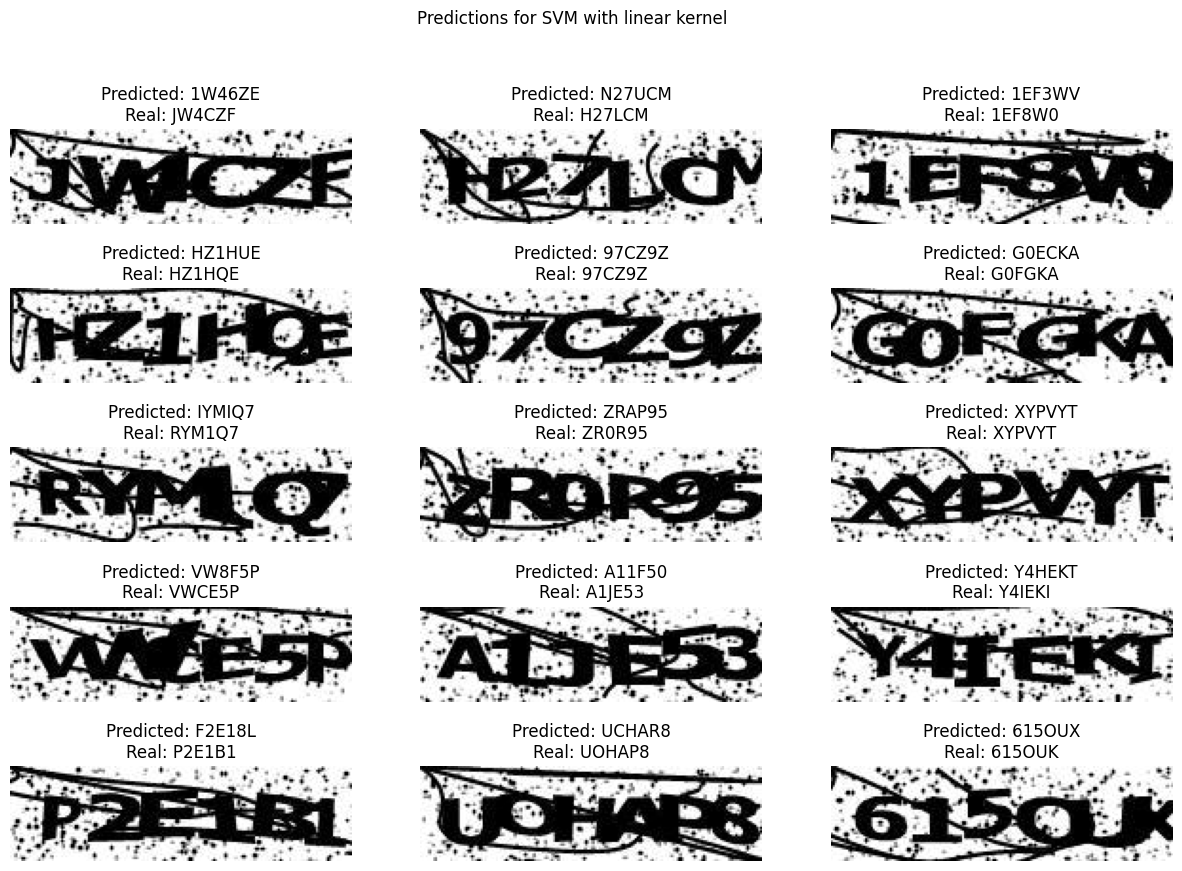

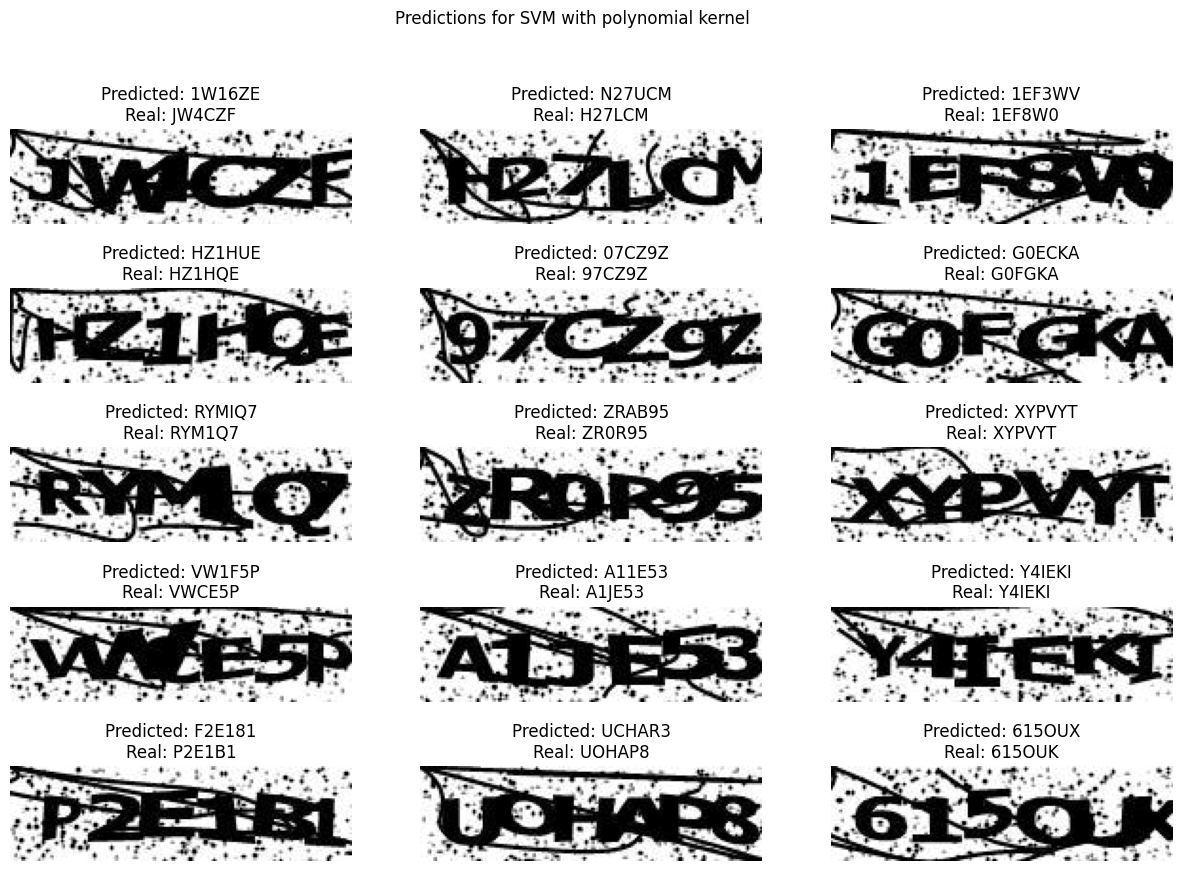

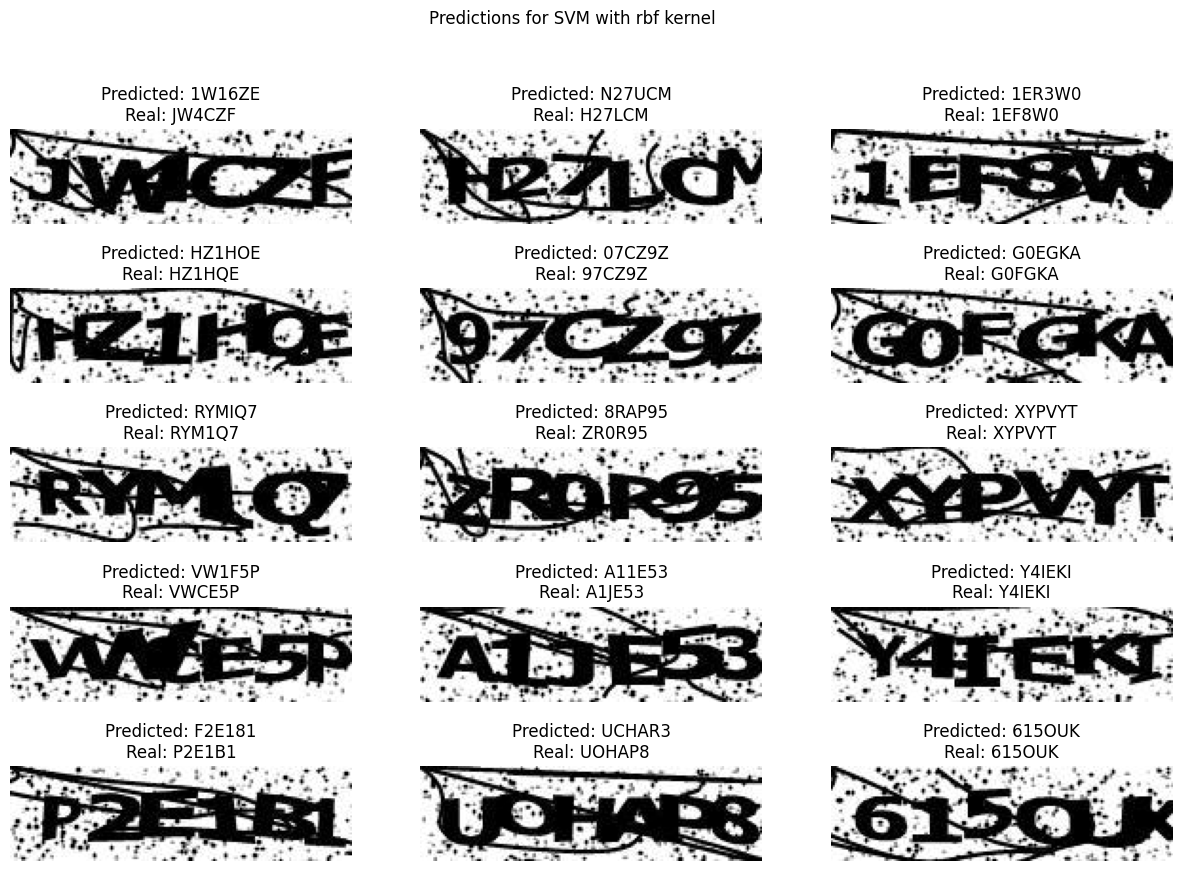

In [20]:
def show_svm_predictions(models: dict, captchas: dict, rows_amount: int = 5):
    for kernel_type in models.keys():
        fig, axs = plt.subplots(
            nrows=rows_amount,
            ncols=3,
            figsize=(15, 10),
            squeeze=False,
        )
        fig.suptitle(f"Predictions for SVM with {kernel_type} kernel")

        svm_model = models[kernel_type]
        for row in range(rows_amount):
            for col in range(3):
                captcha = captchas[TEST][row * 3 + col]

                predicted_captcha = ""
                for char_idx in range(6):
                    X_test = np.array([captcha["hog_features"]])
                    prediction = svm_model[char_idx]["model"].predict(X_test)
                    predicted_captcha += int_to_char[prediction[0]]

                axs[row, col].imshow(captcha["image"], cmap="gray")
                axs[row, col].set_title(f"Predicted: {predicted_captcha}\nReal: {captcha['label']}")
                axs[row, col].axis("off")

        plt.show()

show_svm_predictions(svm_models, captchas)

### Avaliação do Modelo
A primeira métrica a ser observada entre os modelos é o tempo de treinamento. A célula a seguir mostra, em um gráfico de barras, o tempo necessário para realizar o treinamento com cada um dos kernels.

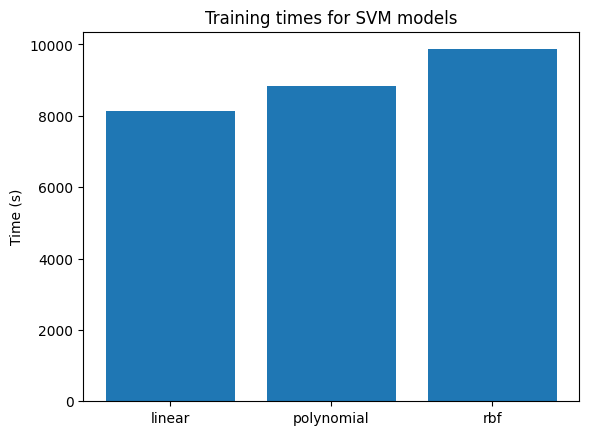

In [21]:
def plot_svm_training_times(svm_models: dict):
    plt.title("Training times for SVM models")

    train_times = {}
    for kernel_type in svm_models.keys():
        total_train_time = sum(model["train_time"] for model in svm_models[kernel_type].values())
        train_times[kernel_type] = total_train_time

    plt.bar(train_times.keys(), train_times.values())
    plt.ylabel("Time (s)")
    plt.show()


plot_svm_training_times(svm_models)

#### Obtenção de métricas
Para avaliar os resultados de treinamento, será calculada a acurácia acumulada por quantidade de caracteres corretamente preditos de cada modelo. Além disso, o tempo necessário para fazer cada uma das predições também será coletado.

In [22]:
def collect_svm_evaluation_metrics(models: dict, captchas: dict) -> dict:
    metrics = {
        svm_kernel: {
            "average_prediction_time": 0,
            "total_prediction_time": 0,
            "accuracies": {
                correct_chars_amount: {
                    "total": 0,
                    "percentage": 0,
                } for correct_chars_amount in range(7)
            },
        } for svm_kernel in models.keys()
    }

    for kernel_type in models.keys():
        time_per_prediction = []
        for captcha in captchas[TEST]:
            # Predicting the captcha
            start_time = time.time()
            predicted_captcha = ""
            for char_idx in range(6):
                X_test = np.array([captcha["hog_features"]])
                prediction = models[kernel_type][char_idx]["model"].predict(X_test)
                predicted_captcha += int_to_char[prediction[0]]
            end_time = time.time()
            time_per_prediction.append(end_time - start_time)

            # Evaluating the prediction
            correct_chars_amount = 0
            for char_idx in range(6):
                if captcha["label"][char_idx] == predicted_captcha[char_idx]:
                    correct_chars_amount += 1

            # Accumulating the accuracy
            if correct_chars_amount == 0:
                metrics[kernel_type]["accuracies"][0]["total"] += 1
            else:
                for char_amount in range(correct_chars_amount):
                    metrics[kernel_type]["accuracies"][char_amount+1]["total"] += 1

        metrics[kernel_type]["average_prediction_time"] = np.mean(time_per_prediction)
        metrics[kernel_type]["total_prediction_time"] = np.sum(time_per_prediction)
        for char_amount in metrics[kernel_type]["accuracies"].keys():
            metrics[kernel_type]["accuracies"][char_amount]["percentage"] = (
                metrics[kernel_type]["accuracies"][char_amount]["total"] / len(captchas[TEST])
            )

    return metrics

Para agilizar a avaliação nas reexecuções do script, será salvo um arquivo `pickle` com as métricas coletadas.

In [23]:
def get_evaluation_metrics(svm_models: dict, captchas: dict):
    try:
        with open("models/svm/evaluation_metrics.pkl", "rb") as f:
            return pickle.load(f)
    except:
        metrics = collect_svm_evaluation_metrics(svm_models, captchas)
        with open("models/svm/evaluation_metrics.pkl", "wb") as f:
            pickle.dump(metrics, f)

    return metrics


svm_metrics = get_evaluation_metrics(svm_models, captchas)

#### Acurácia por Caracteres Corretamente Preditos
Será feito um gráfico da acurácia acumulada por quantidade de caracteres corretamente preditos de cada modelo.

C:\Users\Pedro\AppData\Local\Temp\ipykernel_13304\2781325683.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


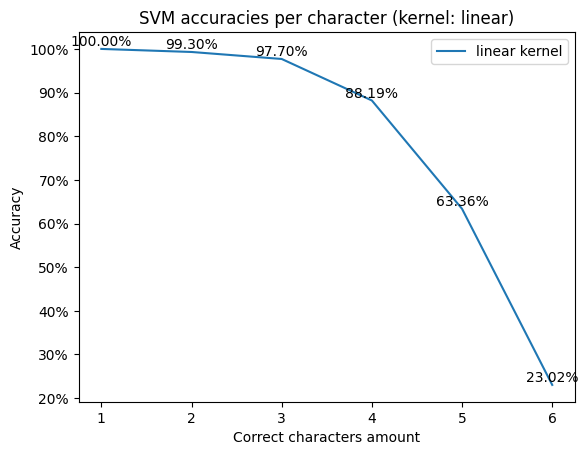

C:\Users\Pedro\AppData\Local\Temp\ipykernel_13304\2781325683.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


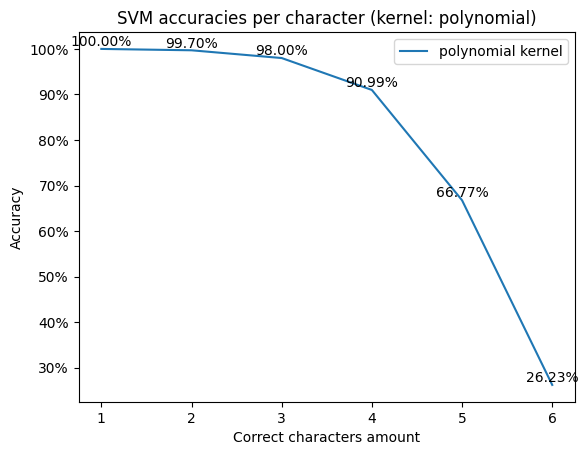

C:\Users\Pedro\AppData\Local\Temp\ipykernel_13304\2781325683.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


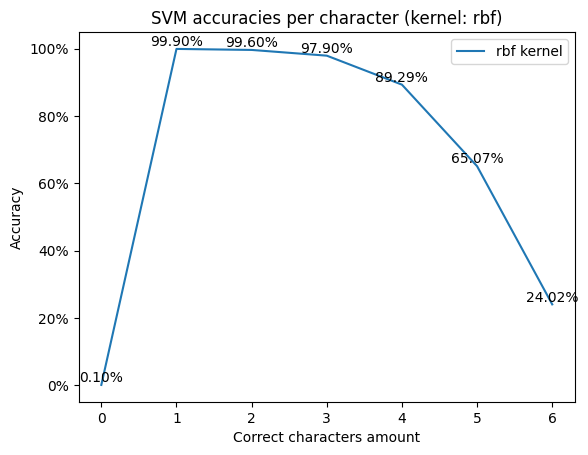

In [29]:
def plot_svm_accuracy(svm_metrics: dict):
    for svm_kernel in svm_metrics.keys():
        plt.title(f"SVM accuracies per character (kernel: {svm_kernel})")

        accuracies = [svm_metrics[svm_kernel]["accuracies"][i]["percentage"] for i in range(7)]
        bins = [i for i in range(len(accuracies))]
        if accuracies[0] == 0:
            accuracies = accuracies[1:]
            bins = bins[1:]
        plt.plot(bins, accuracies, label=f"{svm_kernel} kernel")

        plt.xlabel("Correct characters amount")
        plt.ylabel("Accuracy")

        plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
        for i in range(len(bins)):
            plt.text(bins[i], accuracies[i], f"{accuracies[i]*100:.2f}%", ha="center", va="bottom")

        plt.legend()
        plt.show()


plot_svm_accuracy(svm_metrics)

#### Tempo de Predição
Será feito um gráfico de barras do tempo médio necessário para fazer a predição de cada captcha em cada modelo. Além disso, o tempo total necessário para fazer a predição de todos os captchas também será exibido em outro gráfico de barras.

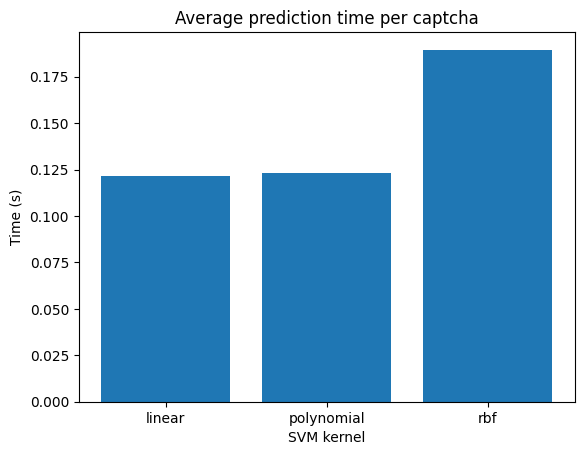

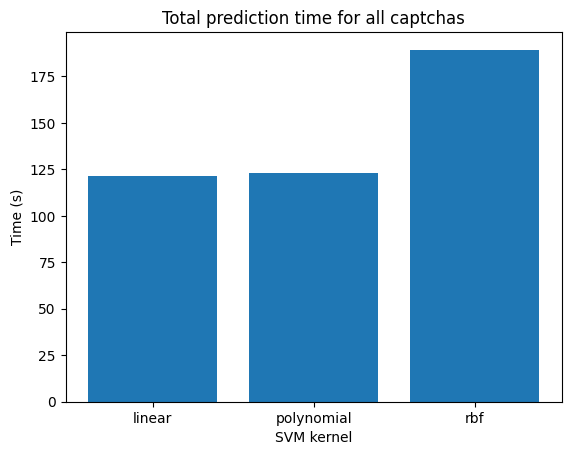

In [25]:
def plot_svm_avg_prediction_time(svm_metrics: dict):
    plt.title("Average prediction time per captcha")

    avg_prediction_times = [svm_metrics[svm_kernel]["average_prediction_time"] for svm_kernel in svm_metrics.keys()]
    plt.bar(svm_metrics.keys(), avg_prediction_times)

    plt.xlabel("SVM kernel")
    plt.ylabel("Time (s)")
    plt.show()


def plot_svm_total_prediction_time(svm_metrics: dict):
    plt.title("Total prediction time for all captchas")

    total_prediction_times = [svm_metrics[svm_kernel]["total_prediction_time"] for svm_kernel in svm_metrics.keys()]
    plt.bar(svm_metrics.keys(), total_prediction_times)

    plt.xlabel("SVM kernel")
    plt.ylabel("Time (s)")
    plt.show()


plot_svm_avg_prediction_time(svm_metrics)
plot_svm_total_prediction_time(svm_metrics)

## Convolutional Neural Network (CNN)
Para realizar as convoluções em código será utilizada a biblioteca `keras` que é uma API de alto nível para construção e treinamento de modelos de aprendizado profundo.

O primeiro passo, após importar os pacotes necessários, é definir a arquitetura da rede neural convolucional. A arquitetura proposta é especificada nos tópicos a seguir:

- Composta por **4 (quatro) camadas convolucionais**, com ativação `relu` e número de filtros dobrando a cada camada.

- Após cada camada convolucional, será adicionada uma camada escondida de **max pooling**, em uma janela de 2x2, para reduzir a dimensionalidade dos mapas de características.

- Após as camadas convolucionais, será adicionada uma camada de **normalização em lote** (Batch Normalization) para normalizar as ativações de cada camada.

- Além disso, será também adicionada uma camada de achatamento (**flatten**) para converter os mapas de características em um vetor unidimensional de tantas posições quanto necessário para o alfabeto de símbolos dos captchas.

Com a criação inicial do modelo, definindo as camadas de entrada e convolucionais, é necessário adicionar as camadas densas para classificação dos caracteres. A arquitetura proposta é especificada nos tópicos a seguir:

- Serão adicionadas tantas camadas densas quanto forem necessárias para representar a quantidade total de caracteres por código Captcha (6).

- Cada camada densa terá 37 neurônios, de forma a representar cada um dos caracteres possíveis através de um vetor.

- A função de ativação utilizada será a `softmax`, que retorna a probabilidade de cada classe.

- Para evitar *overfitting*, será adicionada uma camada de **dropout** após cada camada densa, com uma taxa de `0.5`.

- A função de perda utilizada será a `categorical_crossentropy`, que é adequada para problemas de classificação com mais de duas classes.

- O otimizador utilizado será o `adam`, que é uma extensão do gradiente descendente estocástico que calcula taxas de aprendizado adaptativas para cada parâmetro.

Com o modelo definido, a função a seguir faz a criação e compilamento dele, retornando o modelo pronto para ser treinado.

In [30]:
from keras.layers import Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam


def create_model(
    input_shape: tuple[int, int, int],
    filters: list[int] = [32, 64, 128, 256],
) -> Model:
    # Define the input tensor
    input_layer = Input(shape=input_shape)

    # Build the convolutional layers
    first_conv = Conv2D(filters[0], (3, 3), activation="relu", padding="same")(input_layer)
    first_pool = MaxPooling2D((2, 2))(first_conv)

    second_conv = Conv2D(filters[1], (3, 3), activation="relu", padding="same")(first_pool)
    second_pool = MaxPooling2D((2, 2))(second_conv)

    third_conv = Conv2D(filters[2], (3, 3), activation="relu", padding="same")(second_pool)
    third_pool = MaxPooling2D((2, 2))(third_conv)

    fourth_conv = Conv2D(filters[3], (3, 3), activation="relu", padding="same")(third_pool)
    fourth_pool = MaxPooling2D((2, 2))(fourth_conv)

    normalization_layer = BatchNormalization()(fourth_pool)
    final_pool = MaxPooling2D((2, 2))(normalization_layer)

    # Flatten the output for the dense layers
    flatten = Flatten()(final_pool)

    # Create output layers for each character
    outputs = []
    for i in range(6):  # Assuming 6 characters
        dense = Dense(filters[-1], activation="relu")(flatten)
        dropout = Dropout(0.5)(dense)
        output = Dense(len(char_to_int), activation="softmax", name=f"character_{i+1}_output")(dropout)
        outputs.append(output)

    # Define the model
    model = Model(inputs=input_layer, outputs=outputs)

    # Compile the model
    model.compile(
        optimizer=Adam(),
        loss="categorical_crossentropy",
        metrics=["accuracy"]*6
    )

    return model

### Treinamento do Modelo
Com o modelo compilado, é possível treiná-lo utilizando o conjunto de treino e validá-lo utilizando o conjunto de validação. A função a seguir realiza o treinamento do modelo, utilizando o conjunto de treino e validação, e retorna o histórico do treinamento.

In [31]:
def train_model(model: Model, captchas: dict, batch_size: int = 32, epochs: int = 30) -> Model:
    x_train = np.array([captcha["image"] for captcha in captchas[TRAIN]])

    x_val = np.array([captcha["image"] for captcha in captchas[VALIDATION]])

    y_train = [
        np.array([captcha["vector_label"][i] for captcha in captchas[TRAIN]])
        for i in range(6)
    ]
    y_val = [
        np.array([captcha["vector_label"][i] for captcha in captchas[VALIDATION]])
        for i in range(6)
    ]

    model.fit(
        x=x_train,
        y=y_train,  # Pass a list of labels matching the model's outputs
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_val, y_val),
    )

    return model

A fim de aumentar a quantidade de comparações possíveis, serão treinados ao todo nove modelos, variando a quantidade de épocas de treinamento e a dimensão de saída das camadas convolucionais.

1. **Épocas de Treinamento**: 10, 20 e 30 épocas.

2. **Dimensão de Saída das Camadas Convolucionais**: [8, 16, 32, 64], [16, 32, 64, 128] e [32, 64, 128, 256].

In [ ]:
from keras.saving import load_model


TRAIN_EPOCHS = [10, 20, 30]
FILTERS = [[8, 16, 32, 64], [16, 32, 64, 128], [32, 64, 128, 256]]


def train_models(captchas: dict) -> dict:
    models = {}
    for epochs in TRAIN_EPOCHS:
        for filters in FILTERS:
            model_name = f"filters_{filters[0]}_epochs_{epochs}.keras"

            try:
                model = load_model(f"models/cnn/{model_name}")
            except:
                start_time = time.time()
                model = create_model(
                    (dataset_analysis["max_height"].max(), dataset_analysis["max_width"].max(), 1),
                    filters=filters,
                )
                model = train_model(model, captchas, epochs=epochs)
                end_time = time.time()
                model.save(f"models/cnn/{model_name}")
            
            models[model_name] = {
                "model": model,
                "train_time": end_time - start_time
            }

    return models


cnn_models = train_models(captchas)

Ao todo, foi necessário 1 hora e 34 minutos para treinar os 9 modelos.

### Visualização dos Resultados
Com o modelo treinado, será feita uma breve visualização dos resultados obtidos com o conjunto de dados de teste. A função a seguir faz a predição do modelo utilizando o conjunto de teste e exibe as imagens com seus respectivos rótulos e predições.

In [ ]:
def show_predictions(model: Model, captchas: dict, rows_amount: int = 5):
    _, axs = plt.subplots(
        nrows=rows_amount,
        ncols=3,
        figsize=(15, 10),
        squeeze=False,
    )

    for row in range(rows_amount):
        for col in range(3):
            captcha = captchas[TEST][row * 3 + col]
            prediction = model.predict(np.array([captcha["image"]]))

            predicted_label = convert_int_vectors_to_captchas_labels(np.array(prediction))

            axs[row, col].imshow(captcha["image"], cmap="gray")
            axs[row, col].set_title(f"Predicted: {predicted_label}\nActual: {captcha['label']}")
            axs[row, col].axis("off")

    plt.show()


show_predictions(model, captchas)

### Avaliação do Modelo
Para avaliar o modelo, será feita a predição do conjunto de teste e calculada a acurácia do modelo total e por quantidade de caracteres corretos.

In [ ]:
def evaluate_model(model: Model, captchas: dict) -> pd.DataFrame:
    correct_predictions_histogram = {i+1: 0 for i in range(6)}
    for captcha in captchas[TEST]:
        prediction = model.predict(np.array([captcha["image"]]))
        predicted_label = convert_int_vectors_to_captchas_labels(np.array(prediction))
        
        total_correct = 0
        for i in range(6):
            if captcha["label"][i] == predicted_label[i]:
                total_correct += 1

        for i in range(1, total_correct + 1):
            correct_predictions_histogram[i] += 1

    return pd.DataFrame(correct_predictions_histogram, index=[0])


evaluation = evaluate_model(model, captchas)
evaluation

## Referências
- [**Intuição por trás do algoritmo HOG**](https://www.youtube.com/watch?v=28xk5i1_7Zc)
- [**Explicação mais abstrata do HOG**](https://www.youtube.com/watch?v=RaaGoB8XnxM)